# Identify Malaria Cell thru Images 

# Objective 
Save a LIFE by detecting and deploying Image Cells that contain Malaria or not!

# Dataset

The MalariaSD dataset encompasses diverse stages and classes of malaria parasites, including Plasmodium falciparum, Plasmodium malariae, Plasmodium vivax, and Plasmodium ovale, categorized into four phases: ring, schizont, trophozoite, and gametocyte. This resource aids researchers and healthcare professionals in gaining critical insights into malaria's epidemiology, diagnosis, and treatment.The MP-IDB, featuring high-quality malaria parasite images with the four stages, offers an opportunity for developing and evaluating novel image processing and analysis techniques to enhance malaria diagnosis accuracy and efficiency. In our proposed paper, we utilized these images to create a new dataset using stable diffusion and advanced image processing methods.Applying stable diffusion, we generated a dataset with 16 distinct classes, focusing on single-celled images. Through cropping and enhancement techniques, we produced refined images. This new dataset underwent training via stable diffusion, resulting in an additional 20 images for each class. Our efforts significantly increased the image count from an average of 12 to 40 images per class in the original dataset. This paper contributes to malaria research by expanding the dataset through stable diffusion and image processing. The augmented dataset provides a more comprehensive representation of malaria parasite stages and classes, empowering researchers and healthcare professionals to enhance their understanding of malaria's complexities and improve diagnostic methodologies.
The dataset contains 2 folders

**[Reference](https://ieee-dataport.org/documents/malariasd-malaria-infected-cell-images-dataset)**

- Infected
- Uninfected
And a total of `27,558` images.

You can download the dataset in kaggle:

**[Malaria Cell Images Dataset](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria)**

## What we about to do
* Problem Definition
* Data Collection and Understanding
* Data Preprocessing
* Model Architecture Design
* Training Strategy Development
* Model Evaluation and Interpretation
* Save the Model for Deployment
* Continuous Improvement

## 1. Problem Definition

Malaria is a life-threatening disease caused by parasites transmitted through mosquite bites. Rapid and accurate diagnosis is crucial for effective treatment. This project aims to develop a deep learning model that can automatically classify cell images as infected and uninfected with malaria parasites, which could assis in faster and more accurate diagnosis.

The dataset contains 27,558 images divided into two classes
- Infected: Cells with malaria parasites (Plasmodium Falciparum, Plasmodium malariae, Plasmodium vivax, or Plasmodium ovale)
- Uninfected: Healthy cells without parasites

In [16]:
#Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from collections import Counter

In [17]:
#Set random seed
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Collection and Understanding

Let's explore the dataset structure and visualize some samples from both classes

In [19]:
dataset_path = "cell_images/"
infected_path = os.path.join(dataset_path, "Parasitized")
uninfected_path = os.path.join(dataset_path, "Uninfected")

#Clean Directories
for folder in [infected_path, uninfected_path]:
    for file in os.listdir(folder):
        if file.startswith('.') or not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            os.remove(os.path.join(folder, file))

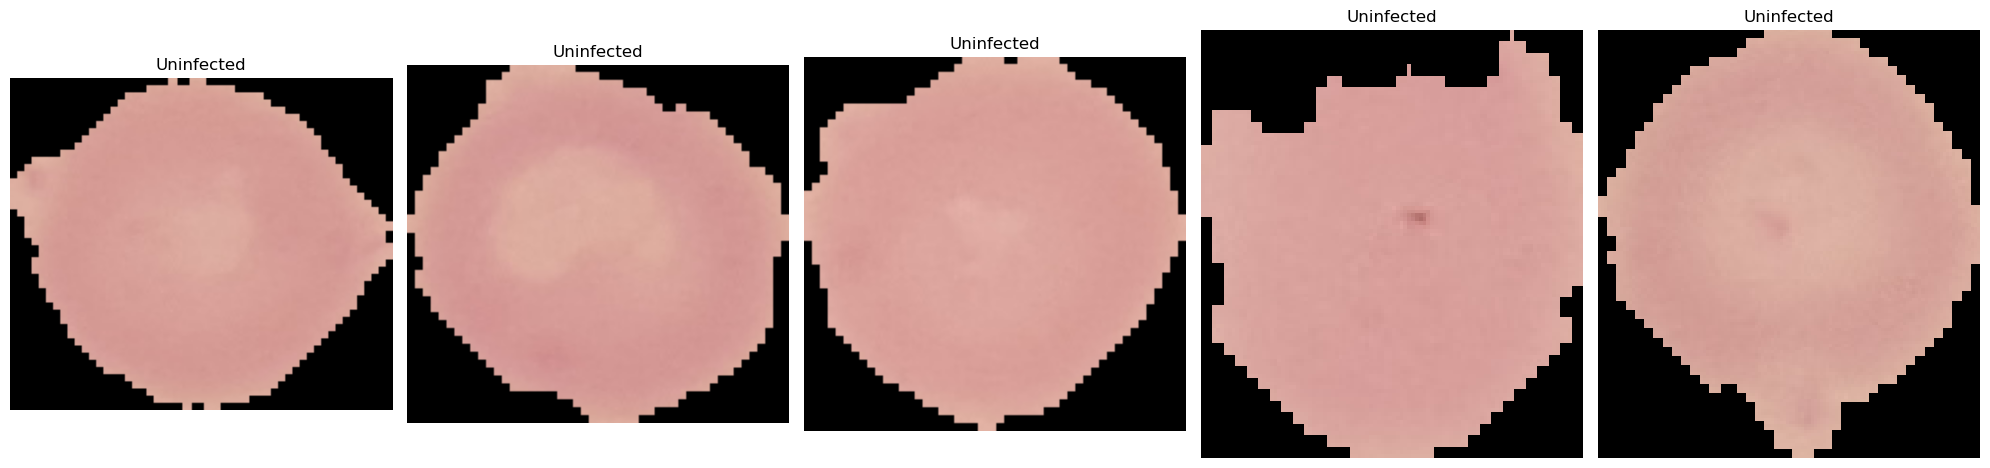

In [20]:
# Visualize Sample Images
def plot_sample_images(infected_path, uninfected_path, num_samples=5):
    plt.figure(figsize=(20,10))

    #Plot infected samples
    infected_file = os.listdir(infected_path)[:num_samples]
    for i, file in enumerate(infected_file):
        img = Image.open(os.path.join(infected_path, file))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title('Infected')
        plt.axis('off')

    #Plot Uninfected samples
    uninfected_file = os.listdir(uninfected_path)[:num_samples]
    for i, file in enumerate(uninfected_file):
        img = Image.open(os.path.join(uninfected_path, file))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title('Uninfected')
        plt.axis('off')

    plt.tight_layout()

    plt.savefig('VisualizeNumberofSamples.png')
    plt.show()

plot_sample_images(infected_path, uninfected_path)

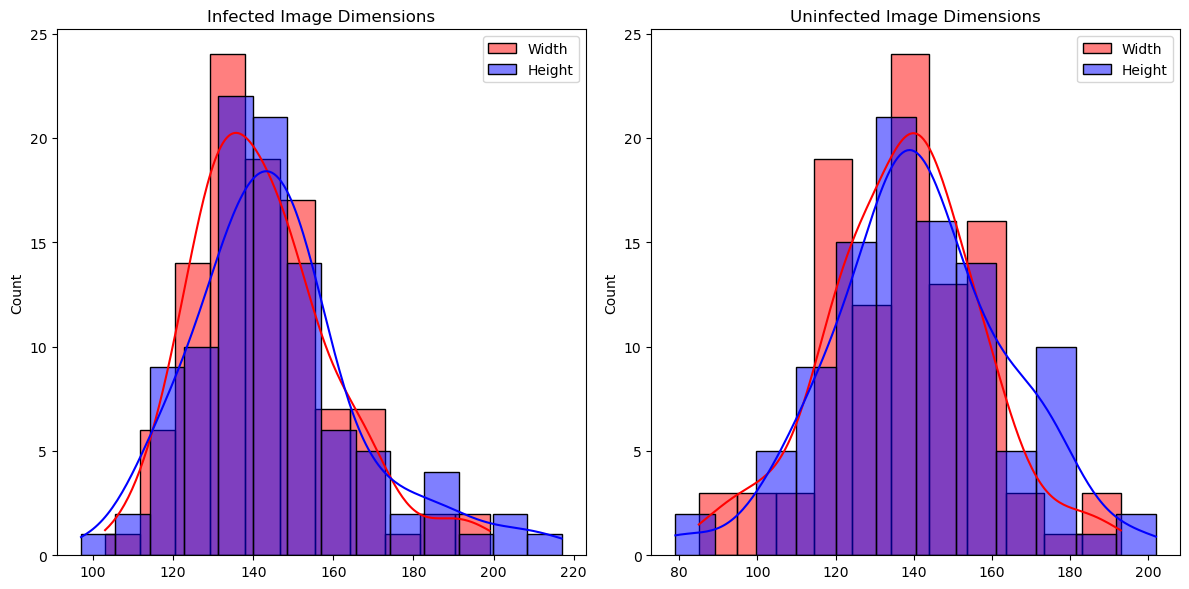

In [21]:
# Check the Image Dimensions
def check_image_dimensions(folder_path, sample_size=100):
    widths = []
    heights = []

    files = os.listdir(folder_path)[:sample_size]
    for file in files:
        img = Image.open(os.path.join(folder_path, file))
        widths.append(img.width)
        heights.append(img.height)

    return widths, heights

infected_widths, infected_heights = check_image_dimensions(infected_path)
uninfected_widths, uninfected_heights = check_image_dimensions(uninfected_path)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(infected_widths, color='red', label='Width', kde=True)
sns.histplot(infected_heights, color='blue', label='Height', kde=True)
plt.title('Infected Image Dimensions')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(uninfected_widths, color='red', label='Width', kde=True)
sns.histplot(uninfected_heights, color='blue', label='Height', kde=True)
plt.title('Uninfected Image Dimensions')
plt.legend()

plt.tight_layout()
plt.savefig('InfectedandUninfectedImageDimensions.png')
plt.show()

## Data Preprocessing

Based on my exploration
1. Resize Images to a consistent dimension (we'll use 64x64 for computational efficiency
2. Normalize pixel values to [0,1] value
3. Split data into training (70%), validation (15%), test (15%) sets
4. Apply data augmentation to increase diversity of training data

In [24]:
# Constants
IMG_SIZE = (64, 64)
BATCH_SIZE= 32
TEST_SIZE= 0.15
VAL_SIZE=0.15

#Create the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SIZE
)

test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(datagen, subset=None):
    return datagen.flow_from_directory(
        dataset_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['Parasitized','Uninfected'],
        shuffle=(subset=='training'),
        subset=subset
    )

#Create generators
train_generator = create_generator(train_datagen, 'training')
val_generator = create_generator(train_datagen, 'validation')
test_generator = create_generator(test_datagen)

#Verify class distribution
print('\nClassification Distribution:')
print(f'Training: {Counter(train_generator.classes)}')
print(f'Validation: {Counter(val_generator.classes)}')
print(f'Test: {Counter(test_generator.classes)}')

Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.

Classification Distribution:
Training: Counter({0: 11713, 1: 11713})
Validation: Counter({0: 2066, 1: 2066})
Test: Counter({0: 13779, 1: 13779})


## Model Architecture Design

We'll use CNN architecture with:
- Convolutional layers for feature extraction
- Max pooling for dimensionality reduction
- Batch normalization for stable training
- Dropout for regularization
- Dense layers for classification

In [26]:
model = Sequential([
    Input(shape=(*IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    #Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

## Training Strategy Development

We'll use:
- Adam Optimmizer with learning rate 0.001
- Binary Crossentropy loss (since this is a binary classification)
- Early Stopping to prevent overfitting
- Learning rate reduction on plateau

In [27]:
#Compile the mode
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             AUC(name='auc', num_thresholds=10000)
            ]
)

In [28]:
#Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=5,mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2,patience=3, min_lr=1e-6, mode='max')
]

In [29]:
#Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data = val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    callbacks = callbacks,
    verbose=1
)

Epoch 1/30


C:\Users\francis\Desktop\conda_envs\ml-dl\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.7258 - auc: 0.7882 - loss: 0.5980 - val_accuracy: 0.8161 - val_auc: 0.9482 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 2/30
  1/732 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8750 - auc: 0.9643 - loss: 0.2956

C:\Users\francis\Desktop\conda_envs\ml-dl\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8750 - auc: 0.9643 - loss: 0.2956 - val_accuracy: 0.8258 - val_auc: 0.9512 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 3/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.9222 - auc: 0.9660 - loss: 0.2229 - val_accuracy: 0.9208 - val_auc: 0.9482 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 4/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8125 - auc: 0.9246 - loss: 0.3929 - val_accuracy: 0.9174 - val_auc: 0.9450 - val_loss: 0.2699 - learning_rate: 0.0010
Epoch 5/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.9356 - auc: 0.9743 - loss: 0.1905 - val_accuracy: 0.8893 - val_auc: 0.9521 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 6/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9375 - auc: 0.9843 - loss: 0.1727 - val_accuracy: 0.8861 - val_auc: 0.9479 - val_loss: 0.3244 - learning_rate: 0.0010
Epoch 7/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.9414 - auc: 0.9759 

## Model Evaluation

Evaluate the model on the test set and analyze its performance

In [37]:
#Evaluationg
def evaluate_model(generator, name):
    generator.reset()
    y_true = []
    y_pred = []

    for i in range(len(generator)):
        x, y = generator[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x, verbose=0).flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    #Calculate the metrics
    accuracy = np.mean((y_pred > 0.5) == y_true)
    roc_auc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else float('nan')

    print(f'\n{name} Evaluation:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {roc_auc:.4f}')

    if len(np.unique(y_true)) > 1:
        print('\nClassification Report:')
        print(classification_report(y_true, (y_pred > 0.5).astype(int),
                                 target_names=['Parasitized', 'Uninfected']))

         #Confusion matrix
        cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Parasitized', 'Uninfected'],
                 yticklabels=['Parasitized', 'Uninfected'])
        plt.title(f'{name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{name}_confusion_matrix.png')
        plt.show()

         #ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{name}_roc_curve.png')
        plt.show()


Training Evaluation:
Accuracy: 0.9531
AUC: 0.9882

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95     11713
  Uninfected       0.93      0.97      0.95     11713

    accuracy                           0.95     23426
   macro avg       0.95      0.95      0.95     23426
weighted avg       0.95      0.95      0.95     23426



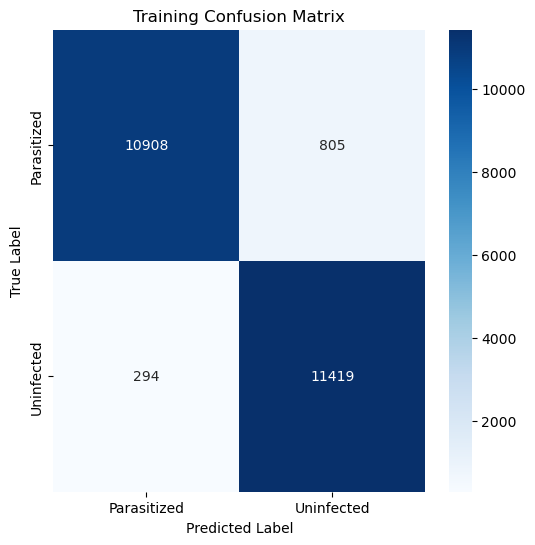

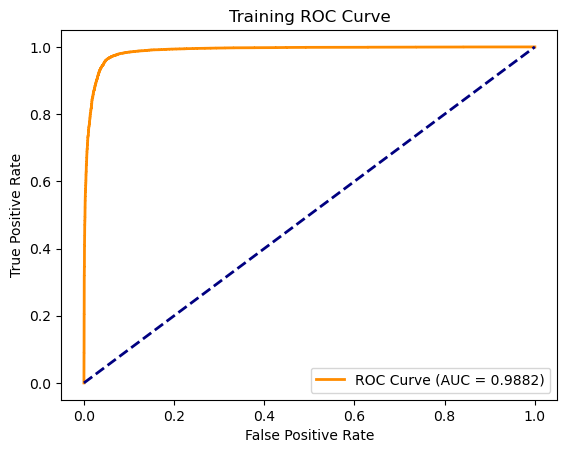


Validation Evaluation:
Accuracy: 0.9281
AUC: 0.9808

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.88      0.92      2066
  Uninfected       0.89      0.97      0.93      2066

    accuracy                           0.93      4132
   macro avg       0.93      0.93      0.93      4132
weighted avg       0.93      0.93      0.93      4132



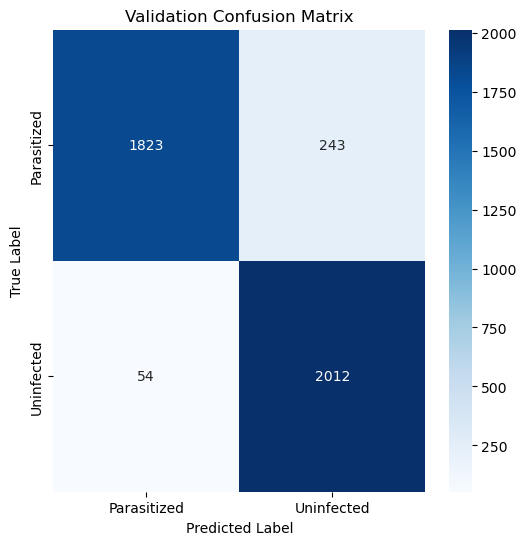

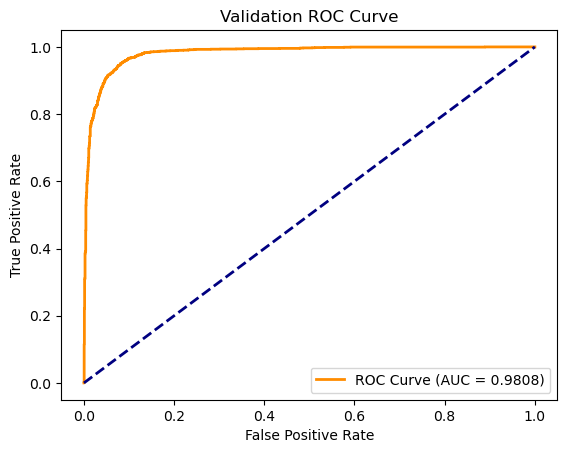


Test Evaluation:
Accuracy: 0.9566
AUC: 0.9902

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.94      0.96     13779
  Uninfected       0.94      0.97      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



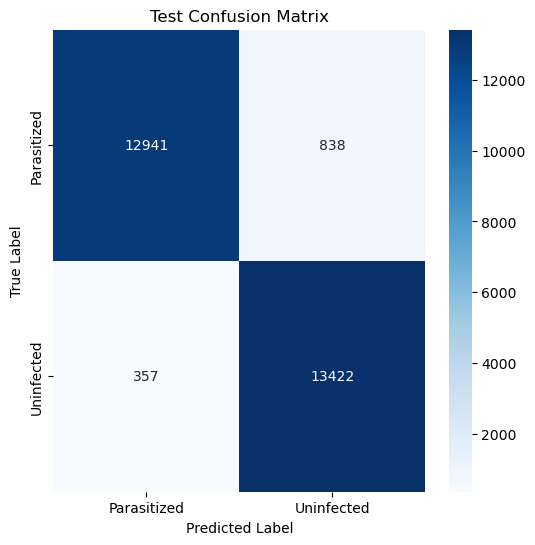

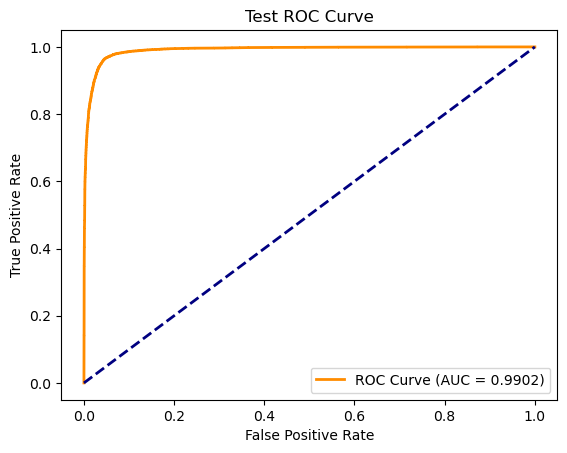

In [38]:
#Evaluate on all set
evaluate_model(train_generator, 'Training')
evaluate_model(val_generator, 'Validation')
evaluate_model(test_generator, 'Test')

## Model Performance
* Training Accuracy: 95.31% | AUC: 0.9882
* Validation Accuracy: 92.81% | AUC: 0.9808
* Test Accuracy: 95.66% | AUC: 0.9902

### Insights
* The model shows excellent discrimination power (AUC > 0.98 in all sets)
* Minimal overfitting (2.5% accuracy drop from train to validation)
* Generalizes well to unseen data (test performance matches training)

## Save the Model for Deployment

In [40]:
#Save model
model.save('malaria_detection_model.keras')
print('Model save successfully!')

Model save successfully!


## Continuous Improvement
Given this is a medical diagnostic tool:

- Consider optimizing for higher recall (reduce false negatives)
- May accept slightly more false positives to catch more infections
- Can adjust classification threshold from 0.5 to 0.4 to boost recall